<a href="https://colab.research.google.com/github/guswns3396/ICME-2023/blob/main/GANs_Exercise_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam, SGD

import torchvision
from torchvision.datasets import MNIST #CIFAR10
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device = get_device()
print(f"Device: {device}")

Device: cuda


In [ ]:
data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

In [ ]:
train_data = MNIST(root = 'data/', train=True, download=True, transform=data_transform)
val_data = MNIST(root = 'data/', train=False, download=True, transform=data_transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 88462724.47it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 3620962.93it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24963061.58it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16035798.63it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
data = torch.utils.data.ConcatDataset([train_data, val_data])

In [ ]:
len(data)

In [ ]:
data_loader = DataLoader(data, batch_size= 64, shuffle=True)

In [ ]:
def denorm(images, means=0.5, stds=0.5):
  images_standard = (images*stds)+means
  return images_standard

In [ ]:
for xb, yb in data_loader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [ ]:
def plot_images(xb):
  grid_img = torchvision.utils.make_grid(denorm(xb), nrow=8)
  plt.figure(figsize=(12,12))
  plt.imshow(grid_img.permute(1,2,0))


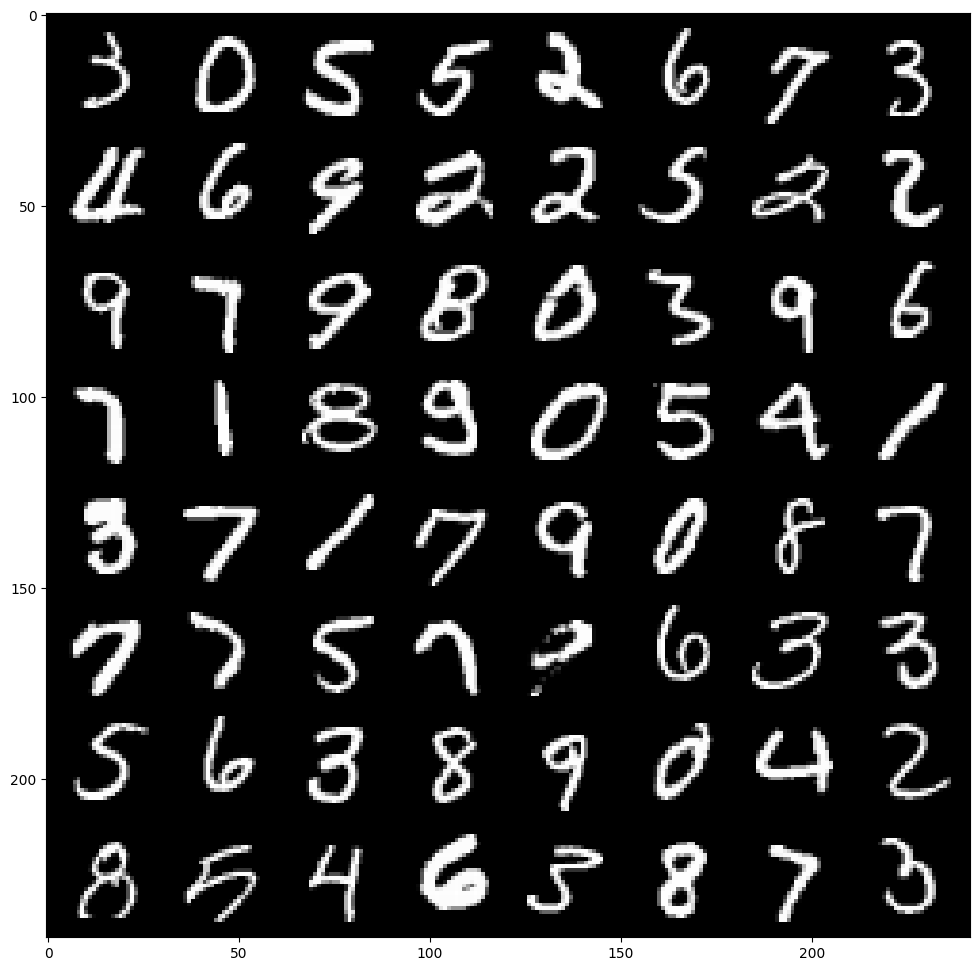

In [ ]:
plot_images(xb)

In [ ]:
class DiscriminatorModel(nn.Module):
    def __init__(self, in_channels=1, hidden_dim=16):
        super().__init__()
        self.network = nn.Sequential(

                nn.Conv2d(in_channels, hidden_dim, 4, 2),
                nn.BatchNorm2d(hidden_dim),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(hidden_dim, hidden_dim * 2, 4, 2),
                nn.BatchNorm2d(hidden_dim* 2),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(hidden_dim * 2, 1, 4, 2)
            )
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

In [ ]:
nn.BatchNorm2d?

In [ ]:
discriminator = DiscriminatorModel(1, 64)
temp = discriminator(xb)
print(temp.shape)

torch.Size([64])


In [ ]:
latent_dimension = 64

In [ ]:
class GeneratorModel(nn.Module):
    def __init__(self, latent_dim=latent_dimension, hidden_dim=64, out_channels=1):
      super().__init__()
      self.network = nn.Sequential(
          nn.ConvTranspose2d(latent_dim, hidden_dim*4, 3, 2),
          nn.BatchNorm2d(hidden_dim*4),
          nn.ReLU(inplace=True),

          nn.ConvTranspose2d(hidden_dim*4, hidden_dim*2, 4, 1),
          nn.BatchNorm2d(hidden_dim*2),
          nn.ReLU(inplace=True),

          nn.ConvTranspose2d(hidden_dim*2, hidden_dim, 3, 2),
          nn.BatchNorm2d(hidden_dim),
          nn.ReLU(inplace=True),

          nn.ConvTranspose2d(hidden_dim, out_channels, 4, 2),
          nn.Tanh()
      )

    def forward(self, input):
      output = self.network(input)
      return output

In [ ]:
generator = GeneratorModel()
test_vec = torch.randn((10,latent_dimension,1,1)) #batch_size, channels, height, width
temp = generator(test_vec)
print(temp.shape)

In [ ]:
batched_test_vector = torch.randn((64,64,1,1))
test_images = generator(batched_test_vector)
plot_images(test_images)

In [ ]:
def discriminator_training_step(real_images, disc_opt):
  num = real_images.shape[0]
  criterion = torch.nn.BCEWithLogitsLoss()
  disc_opt.zero_grad()


  real_targets = torch.ones(num, device=device)
  real_predictions = discriminator(real_images)
  real_loss = criterion(real_predictions, real_targets)


  batched_random_vector = torch.randn((num, latent_dimension,1,1), device=device)
  fake_images = generator(batched_random_vector)
  fake_targets = torch.zeros(num, device=device)
  fake_predictions = discriminator(fake_images)
  fake_loss = criterion(fake_predictions, fake_targets)

  loss = real_loss + fake_loss
  loss.backward()
  disc_opt.step()

  return loss.detach().item()

In [ ]:
def generator_training_step(gen_opt, batch_size=64):
  criterion = torch.nn.BCEWithLogitsLoss()
  gen_opt.zero_grad()

  batched_random_vector = torch.randn((batch_size, latent_dimension,1,1), device=device)
  fake_images = generator(batched_random_vector)
  targets = torch.ones(batch_size, device=device)
  predictions = discriminator(fake_images)
  loss = criterion(predictions, targets)

  loss.backward()
  gen_opt.step()

  return loss.detach().item()

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
def train_models(epochs=50, lr=0.0002):
  gen_opt = torch.optim.Adam(generator.parameters(), lr=lr, betas = (0.5, 0.999))
  disc_opt = torch.optim.Adam(discriminator.parameters(), lr=lr, betas = (0.5, 0.999))


  for epoch in range(epochs):
    gen_losses = []
    disc_losses = []

    for real_images, _ in data_loader:
      real_images = real_images.to(device)
      disc_loss = discriminator_training_step(real_images, disc_opt)
      gen_loss = generator_training_step(gen_opt)

      gen_losses.append(gen_loss)
      disc_losses.append(disc_loss)

    gen_epoch_loss = torch.tensor(gen_losses).mean().item()
    disc_epoch_loss = torch.tensor(disc_losses).mean().item()

    print(F"Epoch: {epoch+1} \t Disc Loss: {disc_epoch_loss} \t Gen Loss: {gen_epoch_loss}")

    generator.eval()
    fake_images = generator(fixed_random_vector)
    grid_img = torchvision.utils.make_grid(denorm(fake_images.detach().cpu()), nrow=8)
    plt.figure(figsize=(8,8))
    plt.imshow(grid_img.permute(1,2,0))
    plt.show()
    generator.train()

In [ ]:
fixed_random_vector = torch.randn((64, latent_dimension,1,1), device=device)
generator = GeneratorModel().to(device)
generator.apply(weights_init)
discriminator = DiscriminatorModel().to(device)
discriminator.apply(weights_init)

In [ ]:
train_models(epochs=50)

## Exercise

I had assumed that a latent dimension of 64 would suffice. However, this may not be optimal. Too low a latent dimension, and you're choking your model's power. Too high and you're wasting computation.

In this exercise, I invite you to try to find a better dimension of the latent space. I would try dimensions of 32 and then 128, but you can make these decisions. Please remember, *if you change your latent dimension, you will have to make changes to your generator*...or you final output will not have the right shape (in this case, (1, 28, 28)).